In [1]:
import torch
from torch import nn
from torch.autograd.functional import vhp
import copy
import numpy as np

torch.manual_seed(0)

In [2]:

# Following are utilities to make nn.Module "functional", in the sense of 
#    being from or compatible with the torch.autograd.functional library. 
#
# borrowed from the link I posted in comment
def del_attr(obj, namesplit): # why, why, why? But it definitely breaks without this. 
    if len(namesplit) == 1:
        delattr(obj, namesplit[0])
    else:
        del_attr(getattr(obj, namesplit[0]), namesplit[1:])

def set_attr(obj, namesplit, val):
    if len(namesplit) == 1:
        setattr(obj, namesplit[0], val)
    else:
        set_attr(getattr(obj, namesplit[0]), namesplit[1:], val)

def make_functional(model):
    orig_params = tuple(model.parameters())
    orig_grad = capture_gradients(model)
    # Remove all the parameters in the model, because reasons. 
    names = []
    for name, p in list(model.named_parameters()):
        del_attr(model, name.split("."))
        names.append(name)
    return orig_params, orig_grad, names

def restore_model(model, names, params, grad):
    load_weights(model, names, params, as_params=True)
    for k, v in model.named_parameters():
        if grad[k+'.grad']:
            v.grad = grad[k].clone().detach()
        else:
            v.grad = None

def load_weights(model, names, params, as_params=False):
    for name, p in zip(names, params):
        if not as_params:
            set_attr(model, name.split("."), p)
        else:
            set_attr(model, name.split("."), torch.nn.Parameter(p))

def capture_gradients(model): # returns gradients in dict vector form
    g = {}
    for k, v in model.named_parameters():
        gnext = v.grad
        knext = k + '.grad'
        if gnext is not None:
            next_entry = {knext: gnext.clone().detach()}
        else:
            next_entry = {knext: None}
        g.update(next_entry)
    return g
  
# def sigmoid(x):
#     return 1 /(1+torch.exp(-x))

# def sigprime(x):
#     return torch.exp(-x)*sigmoid(x)**2
    

# VHP with respect to model parameters

The following is from a stackoverflow question about applying vhp when models with parameters are involved, as opposed to simpler functions where we don't have to iterate over parameters.

https://stackoverflow.com/questions/68492748/trouble-with-minimal-hvp-on-pytorch-model

This in turn linked to

https://discuss.pytorch.org/t/hvp-w-r-t-model-parameters/83520



In [3]:

# your simple MLP model
class SimpleMLP(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_dim, out_dim),
        )

    def forward(self, x):
        '''Forward pass'''
#         return self.layers(x)
        return torch.sigmoid(self.layers(x))

    



## The "objective function"
The function called objective() is important here. It must generate a scalar from a tensor. It takes the output of the model (called mlp(), generates a vector) and operates on it, to produce a scalar. In actual use, objective will probably somehow compare the mlp output to some ground truth. 

If objective  is linear in its input, the second derivatives in the Hessian will be zero. For some reason, Pytorch barfs on this, rather than just giving zeros.

Using absolute value as objective(), though, seems to be ok. Sure, abs is not linear, but doesn't it make the Hessian zero everywhere except X=0? Why shouldn't this cause the same issue? 

In [4]:
def objective(X):
    return torch.sum(X**2)

In [5]:
# This is how we trick vhp into doing the Hessian with respect to params and not other inputs.
def loss_wrt_params(model, objective, pnames, inputs, *new_params):
    load_weights(model, pnames, new_params) # Weird! We removed the params before. 
    if len(tuple(model.named_parameters())) == 0:
        print('No parameters!')
    for n,p in model.named_parameters():
        print(n,p)
    out = model(inputs)  # model output
    loss = objective(out)  # comparing model to ground truth, in practice. 
    
    loss.backward(retain_graph=True)
    return loss


In [6]:

# your model instantiation
in_dim, out_dim = 3, 2
mlp = SimpleMLP(in_dim, out_dim)

v_to_dot = tuple([torch.rand_like(p.clone().detach()) for p in mlp.parameters()])

xglobal = torch.rand((in_dim,)) # need to eliminate this and other global refs. 


In [7]:
mlp(xglobal)

tensor([0.5391, 0.5021], grad_fn=<SigmoidBackward>)

In [8]:
mlpsave = copy.deepcopy(mlp)


In [9]:
#make model's parameters functional
orig_params, orig_grad, names = make_functional(mlp)  #munches mlp by removing params
params_to_pass = tuple(p.detach().requires_grad_() for p in orig_params)

loss_to_pass = lambda p : loss_wrt_params(mlp, objective, names, xglobal, p)

In [10]:
mlpsave(xglobal)

tensor([0.5391, 0.5021], grad_fn=<SigmoidBackward>)

In [12]:
mlp = copy.deepcopy(mlpsave)
print(loss_to_pass(params_to_pass))

TypeError: cannot assign 'tuple' as parameter 'weight' (torch.nn.Parameter or None expected)

In [11]:
loss_value, hessian = torch.autograd.functional.vhp(loss_to_pass, params_to_pass, \
                                                    v_to_dot, strict=True)


TypeError: <lambda>() takes 1 positional argument but 2 were given

In [14]:
loss_to_pass(params_to_pass)

AttributeError: 'Linear' object has no attribute 'bias'

In [24]:
def f(x,y):
    return x+y

f1 = lambda z : f(z,1)

In [26]:
f1(torch.tensor([3,2,1]))

tensor([4, 3, 2])

In [ ]:
restore_model(mlp, names, orig_params, orig_grad)
lossp = loss_wrt_params(*orig_params) # this calls backward on loss = objective(out)
grad = capture_gradients(mlp)
print('grad is:', grad)
# print('dLdY check is:', torch.sum())

print('loss_value:', loss_value)
print('lossp:', lossp)
print('H(params):', hessian)

#L=torch.sum(Y**2)/2
#Y = W * x + B
# dLdY = sum(Y)*ones(Y.shape)
# dYdWij = sum(x)


In [ ]:
loss_value, lossp

In [ ]:
xchk =  torch.rand((in_dim,))


In [ ]:
outchk = mlp(xchk)
print(outchk)
losschk = objective(outchk)
print(losschk)

In [ ]:
capture_gradients(mlp)

In [ ]:
grad

## Check the Hessian of this "parameter trick" function
First, make sure I can get the gradient of a linear function with respect to its inputs correct. The result for the in_dim to out_dim transform here should be the sum over rows of the weight matrix.  

In [ ]:
class JustLinear(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_dim, out_dim),
        )

    def forward(self, x):
        '''Forward pass'''
#         return self.layers(x)
        return self.layers(x)



In [ ]:
print(in_dim, out_dim)

In [ ]:
xglobal.grad = None

xglobal.retain_grad = False
xglobal.requires_grad = True
f = JustLinear(in_dim, out_dim)

fx = f(xglobal)
ext_grad = torch.ones_like(fx)
fx.backward(gradient=ext_grad, retain_graph=True, inputs=xglobal)
print(fx)


In [ ]:
print('the result of backward is:\n', xglobal.grad,'\n')
print('Note that backward sums over components of vectors, i.e. it computes the Jacobian')
print('and then sums all changes due to each parameter.')

print('the sum over rows of the weight matrix is:')
for p in f.named_parameters():
    if 'weight' in p[0]:
        print(torch.sum(p[1],0))
        
print('\nThese should be vectors with',in_dim,'components.')

We are taking derivatives of each output component and summing over them. I guess the sum is implicit in backward()? Otherwise I don't see how it comes about. I feel like each output component should have its own value of the gradient here. I guess I am thinking backward() should compute the Jacobian, but it does not. OMG the documentation says exactly that. Ok. 

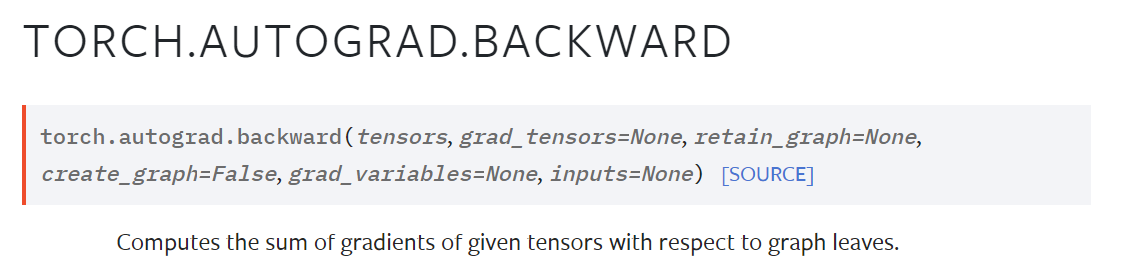